**This is based on an example from Deep Learning With Python book.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

## Loading the dataset

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.
/home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/btek/.conda/envs/kerasg

SEARCHING /home/btek/.keras/datasets/boston_housing.npz boston_housing.npz
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of f553886a1f8d56431e820c5b82552d9d95cfcb96d1e678153f8839538947dff5 so we will re-download the data.
57344/57026 [==============================] - 0s 5us/step


In [3]:
# take a look at the data

print(f'Training data : {train_data.shape}')
print(f'Test data : {test_data.shape}')
print(f'Training sample : {train_data[0]}')
print(f'Training target sample : {train_targets[0]}')

Training data : (404, 13)
Test data : (102, 13)
Training sample : [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
Training target sample : 15.2


## Preparing the data

We are going to do a feature normalization . Feature normalizaion is when you subtract the mean of the feature from each feature and divide each result by the standard deviation.


In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# Note that the quantities used for normalizing the test data are computed using the
# training data. You should never use in your workflow any quantity computed on the
# test data, even for something as simple as data normalization.

In [5]:
# this is to allow focusing layer more room in the input domain
pad = 5
train_data2 = np.zeros(shape=(train_data.shape[0],train_data.shape[1]+2*pad), dtype=train_data.dtype)
test_data2 = np.zeros(shape=(test_data.shape[0],test_data.shape[1]+2*pad), dtype=train_data.dtype)
train_data2[:,pad:-pad]=train_data
test_data2[:,pad:-pad]=test_data


In [6]:
from keras_utils import SGDwithLR, RMSpropwithClip
lr_dict = {'all':0.01,
           'focus-1/Sigma:0': 0.01,'focus-1/Mu:0': 0.01,'focus-1/Weights:0': 0.01,
           'focus-2/Sigma:0': 0.01,'focus-2/Mu:0': 0.01,'focus-2/Weights:0': 0.01,
           'dense_1/Weights:0':0.01}
        
#lr_dict = {'all':0.0001}

mom_dict = {'all':0.9}
#decay_dict = {'all':0.9}
#mom_dict = {'all':0.9,'focus-1/Sigma:0': 0.25,'focus-1/Mu:0': 0.25,
#           'focus-2/Sigma:0': 0.25,'focus-2/Mu:0': 0.25}
    
decay_dict = {'all':0.9, 'focus-1/Sigma:0': 0.1,'focus-1/Mu:0':0.1,
              'focus-2/Sigma:0': 0.1,'focus-2/Mu:0': 0.1}

clip_dict = {'focus-1/Sigma:0':(0.05,1.0),'focus-1/Mu:0':(0.0,1.0),
             'focus-2/Sigma:0':(0.05,1.0),'focus-2/Mu:0':(0.0,1.0)}


## Building the network

In [7]:
from keras import models
from keras import layers
from Kfocusing import FocusedLayer1D
from keras.optimizers import RMSprop



def build_model(N=64,mod='dense', optimizer_s='SGDwithLR'):
    
    model = models.Sequential()
    if mod=='dense':
        model.add(layers.Dense(N, activation='relu', input_shape=(train_data.shape[1],),name='dense-1'))
        model.add(layers.Dense(N, activation='relu',name='dense-2'))
    elif mod=='focused':
        model.add(FocusedLayer1D(units=N,
                                  name='focus-1',
                                  activation='relu',
                                  init_sigma=0.25, 
                                  init_mu='spread',
                                  init_w= None,
                                  train_sigma=True, 
                                  train_weights=True,
                                  train_mu = True,normed=2))
        
        
        model.add(FocusedLayer1D(units=N,
                                  name='focus-2',
                                  activation='relu',
                                  init_sigma=0.25, 
                                  init_mu='spread',
                                  init_w= None,
                                  train_sigma=True, 
                                  train_weights=True,
                                  train_mu = True,normed=2))
        
    model.add(layers.Dense(1,name='dense-3'))
    

    if optimizer_s == 'SGDwithLR':
        opt = SGDwithLR(lr_dict, mom_dict,decay_dict,clip_dict)#, decay=None)
    elif optimizer_s=='RMSpropwithClip':
        opt = RMSpropwithClip(lr=0.001, rho=0.9, epsilon=None, decay=0.0,clips=clip_dict)
    else:
        opt= SGD(lr=0.01, momentum=0.9)#, decay=None)
    
    
    
    model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])
    return model

## K-fold validation

In [8]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
mod='focused'
N=64
all_scores = []

for i in range(k):
    print(f'Processing fold # {i}')
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
                            [train_data[:i * num_val_samples],
                            train_data[(i+1) * num_val_samples:]],
                            axis=0)
    partial_train_targets = np.concatenate(
                            [train_targets[:i * num_val_samples],
                            train_targets[(i+1)*num_val_samples:]],
                            axis=0)
    model = build_model(N,mod)
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold # 0
{'name': 'focus-1'}
{'name': 'focus-2'}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Clipping variable focus-1/Sigma:0  to  <tf.Variable 'SGDwithLR/clipsfocus-1/Sigma_0:0' shape=(2,) dtype=float32_ref>
Processing fold # 1
{'name': 'focus-1'}
{'name': 'focus-2'}
Processing fold # 2
{'name': 'focus-1'}
{'name': 'focus-2'}
Processing fold # 3
{'name': 'focus-1'}
{'name': 'focus-2'}


In [9]:
print(f'all_scores : {all_scores}')
print(f'mean all scores : {np.mean(all_scores)}')
# dense_scores : [2.095678972725821, 2.220593815982932, 2.859968412040484, 2.4053568893139907]
# mean scores 2.3953

# focus scores
#all_scores : [2.0599809353894525, 2.7440072522305026, 2.6911646399167504, 2.2415692912469996]
#mean all scores : 2.4341805296959262

all_scores : [8.79262402978274, 8.440304236836953, 5.7631691658850945, 7.286687888721429]
mean all scores : 7.570696330306554


In [10]:
model = build_model(N,'focused')
model.fit(train_data2, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data2, test_targets)

{'name': 'focus-1'}
{'name': 'focus-2'}
102/102 [==============================] - 0s 3ms/step


In [11]:
# dense result Mae:  2.6280728414946912 Mse:  16.77931198419309
print("Mae: ",test_mae_score, "Mse: ",test_mse_score)
# focus Mae: Mae: 2.7198990747040392 Mse:  19.143169926662072
# focus zero-padded Mae:  2.629578020058426 Mse:  14.96112060546875

Mae:  6.573432548373353 Mse:  83.2877062629251


In [12]:
R = 5
list_mse_focus =[]
list_mae_focus =[]
for r in range(R):
    model = build_model(N,'focused',optimizer_s='RMSpropwithClip')
    history=model.fit(train_data2, train_targets, epochs=80, batch_size=16, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data2, test_targets)
    list_mse_focus.append(test_mse_score)
    list_mae_focus.append(test_mae_score)


{'name': 'focus-1'}
{'name': 'focus-2'}
102/102 [==============================] - 0s 3ms/step
{'name': 'focus-1'}
{'name': 'focus-2'}
102/102 [==============================] - 0s 4ms/step
{'name': 'focus-1'}
{'name': 'focus-2'}
102/102 [==============================] - 0s 4ms/step
{'name': 'focus-1'}
{'name': 'focus-2'}
102/102 [==============================] - 0s 4ms/step
{'name': 'focus-1'}
{'name': 'focus-2'}
102/102 [==============================] - 1s 5ms/step


In [13]:
R = 5
list_mse_dense =[]
list_mae_dense =[]
for r in range(R):
    model = build_model(N,'dense',optimizer_s='RMSpropwithClip')
    history=model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    list_mse_dense.append(test_mse_score)
    list_mae_dense.append(test_mae_score)

102/102 [==============================] - 1s 5ms/step


In [14]:
import numpy as np
from scipy.stats import ttest_ind
root = 'outputs/transfer-cifar10/'
fs=np.array(list_mae_focus)
ds=np.array(list_mae_dense)
print("focused:",fs)
print("Focus mean",np.mean(fs,axis=0))
print("Focus std",np.std(fs,axis=0))
print("Focus min",np.min(fs,axis=0))

print("Dense:",ds)
print("Dense mean",np.mean(ds,axis=0))
print("Dense std",np.std(ds,axis=0))
print("Dense min",np.min(ds,axis=0))

ttest_ind(fs,ds)

focused: [2.53183164 2.52198186 2.63702825 2.68187948 2.60357109]
Focus mean 2.5952584640652523
Focus std 0.061170972659700354
Focus min 2.521981856402229
Dense: [2.58525176 2.74632061 2.49758059 2.57136992 2.70608645]
Dense mean 2.621321867026535
Dense std 0.09156186208961875
Dense min 2.497580593707515


Ttest_indResult(statistic=-0.47338223756678277, pvalue=0.6485887038779921)

In [8]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
N=64

# plot training curves
model1 = build_model(N,'focused',optimizer_s='RMSpropwithClip')
history_dense=model1.fit(train_data2, train_targets, epochs=250, batch_size=16, 
                         validation_data=(test_data2, test_targets),verbose=0)

model2 = build_model(N,'dense',optimizer_s='RMSpropwithClip')
history_focus=model2.fit(train_data, train_targets, epochs=250,
                         validation_data=(test_data, test_targets), batch_size=16, verbose=0)  
    


W0809 23:48:22.459196 140711336515392 deprecation_wrapper.py:119] From /home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 23:48:22.488465 140711336515392 deprecation_wrapper.py:119] From /home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 23:48:22.489566 140711336515392 deprecation_wrapper.py:119] From /home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 23:48:22.508664 140711336515392 deprecation_wrapper.py:119] From /home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please 

{'name': 'focus-1'}
{'name': 'focus-2'}


W0809 23:48:23.809000 140711336515392 deprecation.py:323] From /home/btek/.conda/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CLpping variable focus-1/Sigma:0  to  <tf.Variable 'RMSpropwithClip/clipsfocus-1/Sigma_0:0' shape=(2,) dtype=float32_ref>


In [9]:
history_dense.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [15]:
from importlib import reload

from plot_utils import paper_fig_settings

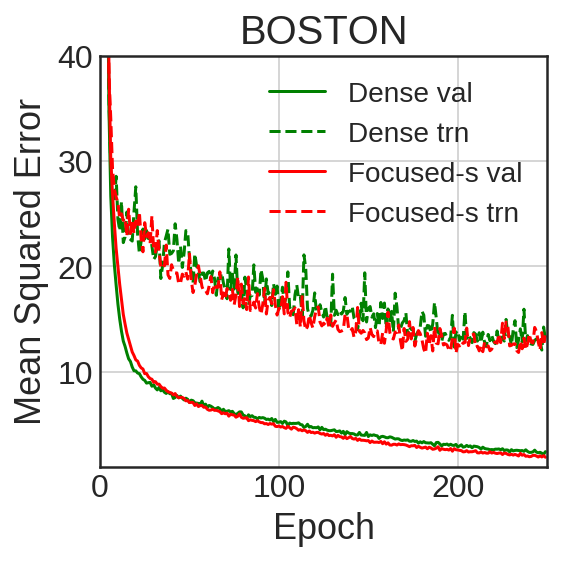

In [20]:


crv_legend =[' Trn', ' Val', 'Valacc', ' Tst']
lin_styles =['-','--',':','--']
leg_list =[]

    
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig_hand=plt.figure(figsize=(4,4))
#ax = fig_hand.gca()


paper_fig_settings(addtosize=4)
plt.plot(history_dense.history['loss'],'g')
plt.plot(history_dense.history['val_loss'],'g--')
plt.plot(history_focus.history['loss'],'r')
plt.plot(history_focus.history['val_loss'],'r--')

plt.legend(['Dense val','Dense trn','Focused-s val','Focused-s trn'])
        
plt.xlim(0,250)
plt.ylim([1,40])
plt.xticks([0,100,200])
plt.grid(True)
#plt.legend(leg_list)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
#plt.tight_layout()
plt.title('BOSTON')
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=.5)
plt.savefig('figures/boston_new.png', format='png', dpi=300)
#fig_hand.savefig('figures/'+title+'.png')


In [17]:
import plot_utils